# Football Probabilities in Python

## Overview

In May 2009,
[Professor David Spiegelhalter](https://en.wikipedia.org/wiki/David_Spiegelhalter) the Professor for the Understanding of Risk at Cambridge University wrote
[an article](http://news.bbc.co.uk/1/hi/programmes/more_or_less/8062277.stm) for the BBC concerning the probable outcomes for that last matches of that Premiership football games.  This article added to another that he had published called
_[One game to play!](https://understandinguncertainty.org/node/228)_ which gives a bit more detail on how some of the figures were calculated.

In this Jupyter notebook, we are going to look at implementing some of the mathematical equations for that article in Python using the
[Numpy](https://numpy.org/) and
[SciPy](https://www.scipy.org/) packages.

## Methods

The article describes the attack strengh/defence weakness method (which is also described in
[How to calculate Poisson distribution for football betting](https://help.smarkets.com/hc/en-gb/articles/115001457989-How-to-calculate-Poisson-distribution-for-football-betting)) and concentrates on the game between Arsenal and Stoke City which was played at the Emirates Stadium on Sunday 24th May at 1600 BST.

Looking at how the
[league table](https://en.wikipedia.org/wiki/2008%E2%80%9309_Premier_League#League_table)
looked at the end of the season and subtracting the goals that we now know Arsenal and Stoke scored, we can setup some variables and check them against the initial values in the article.


In [324]:
# Enable PEP8 code checking.
%load_ext pycodestyle_magic

%pycodestyle_on

In [329]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.ticker import PercentFormatter
from scipy.stats import poisson


class Footy:
    def __init__(self):
        self._data = {}

    def add_team(self,
                 team_name,
                 goals_for,
                 goals_against,
                 home_games,
                 away_games):
        data = self.data()
        team_stats = {
            'goals_for': goals_for,
            'goals_against': goals_against,
            'home_games': home_games,
            'away_games': away_games
        }
        data[team_name] = team_stats
        self.data(data)

    def attack_strength(self, team_name):
        team_average_goals_scored = self.goals_scored(team_name)
        league_average_goals_scored = self.goals_scored()
        attack_strength = team_average_goals_scored
        attack_strength /= league_average_goals_scored
        return round(attack_strength, 2)

    def average_goals_scored(self, average_goals_scored=None):
        if average_goals_scored is not None:
            self._average_goals_scored = average_goals_scored
        return self._average_goals_scored

    def defence_factor(self, team_name):
        team_average_goals_conceeded = self.goals_conceeded(team_name)
        league_average_goals_conceeded = self.goals_conceeded()
        defence_factor = team_average_goals_conceeded
        defence_factor /= league_average_goals_conceeded
        return round(defence_factor, 2)

    def goals_conceeded(self, team_name=None):
        """
        Get the number of goals conceeded.

        Similar in nature to goals_scored.
        """
        data = self.data()

        if team_name:
            goals_conceeded_by_team = data[team_name]['goals_against']
            return goals_conceeded_by_team
        else:
            goals_conceeded = 0

            for team_name in data.keys():
                goals_conceeded += data[team_name]['goals_against']

            return int(round(goals_conceeded / len(data.keys())))

    def goals_scored(self, team_name=None):
        """
        Get the number of goals scored.

        If team_name is provided, the number of goals scored by
        that team is returned.  If not, the average number of
        goals scored by all teams is returned.
        """
        data = self.data()

        if team_name:
            goals_scored_by_team = data[team_name]['goals_for']
            return goals_scored_by_team
        else:
            goals_for = 0

            for team_name in data.keys():
                goals_for += data[team_name]['goals_for']

            return int(round(goals_for / len(data.keys())))

    def data(self, data=None):
        if data is not None:
            self._data = data
        return self._data

    def dataframe(self):
        a = []
        data = self.data()
        attack_strengths = []
        defence_factors = []

        for team_name in data.keys():
            team_dict = data[team_name]
            attack_strength = self.attack_strength(team_name)
            attack_strengths.append(attack_strength)
            defence_factor = self.defence_factor(team_name)
            defence_factors.append(defence_factor)
            team_list = [team_name]

            for value in list(team_dict.values()):
                team_list.append(value)

            a.append(team_list)

        columns = ['team_name']

        for key in list(team_dict.keys()):
            columns.append(key)

        df = pd.DataFrame(a, columns=columns)
        df['attack_strength'] = attack_strengths
        df['defence_factor'] = defence_factors
        return df

    def outcome_probability(self, home_team, away_team, show_plot=True):
        df = self.score_probability(home_team, away_team, False)
        df = df[df.home > df.away]
        home_win_probability = round(sum(df.probability.values), 2)
        df = self.score_probability(home_team, away_team, False)
        df = df[df.home == df.away]
        draw_probability = round(sum(df.probability.values), 2)
        df = self.score_probability(home_team, away_team, False)
        df = df[df.home < df.away]
        away_win_probability = round(sum(df.probability.values), 2)

        if show_plot:
            labels = [f'{home_team} Win', 'Draw', f'{away_team} Win']
            sizes = [home_win_probability, draw_probability,
                     away_win_probability]

            fig1, ax1 = plt.subplots()
            ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                    shadow=True, startangle=90)
            # Equal aspect ratio ensures that pie is drawn as a circle.
            ax1.axis('equal')

            plt.show()

        return (home_win_probability, draw_probability, away_win_probability)

    def plot_goal_probability(self, goals, probability_mass, title):
        plt.bar(goals, probability_mass * 100.0)
        plt.title(title)
        plt.xlabel('Probable Goals')
        plt.ylabel('Percentage (%)')
        plt.show()

    def score_probability(self, home_team, away_team, show_plots=True):
        (home_expected_goals,
         away_expected_goals) = self.average_goals_scored()
        home_expected_goals *= self.attack_strength(home_team)
        home_expected_goals *= self.defence_factor(away_team)
        home_expected_goals = round(home_expected_goals, 2)
        goals = [0, 1, 2, 3, 4, 5, 6]
        probability_mass = poisson.pmf(goals, home_expected_goals)
        home_probability_mass = np.round(probability_mass, 2)
        away_expected_goals *= self.attack_strength(away_team)
        away_expected_goals *= self.defence_factor(home_team)
        away_expected_goals = round(away_expected_goals, 2)
        probability_mass = poisson.pmf(goals, away_expected_goals)
        away_probability_mass = np.round(probability_mass, 2)

        probabilities = []

        for home_team_goal in range(len(goals)):
            for away_team_goal in range(len(goals)):
                probability = home_probability_mass[home_team_goal]
                probability *= away_probability_mass[away_team_goal]
                probability = round(probability * 100.0, 2)
                probabilities.append([home_team_goal, away_team_goal,
                                      probability])

        if show_plots:
            self.plot_goal_probability(goals,
                                       home_probability_mass,
                                       f"{home_team} Goal Probabilty")
            self.plot_goal_probability(goals,
                                       away_probability_mass,
                                       f"{away_team} Goal Probabilty")

        df = pd.DataFrame(probabilities, columns=['home',
                                                  'away',
                                                  'probability'])
        df = df[df.probability != 0]
        df = df.sort_values('probability', ascending=False)
        df = df.reset_index(drop=True)
        return df


footy = Footy()
footy.add_team('Arsenal', 64, 36, 18, 19)
footy.add_team('Aston Villa', 53, 48, 18, 19)
footy.add_team('Blackburn', 40, 60, 18, 19)
footy.add_team('Bolton', 41, 52, 19, 18)
footy.add_team('Chelsea', 65, 22, 19, 18)
footy.add_team('Everton', 53, 37, 19, 18)
footy.add_team('Fulham', 39, 32, 18, 19)
footy.add_team('Hull', 39, 63, 18, 19)
footy.add_team('Liverpool', 74, 26, 18, 19)
footy.add_team('Man City', 57, 50, 18, 19)
footy.add_team('Man United', 67, 24, 19, 18)
footy.add_team('Middlesbrough', 27, 55, 19, 18)
footy.add_team('Newcastle', 40, 58, 19, 18)
footy.add_team('Portsmouth', 38, 56, 19, 18)
footy.add_team('Stoke', 37, 51, 19, 18)
footy.add_team('Sunderland', 32, 51, 18, 19)
footy.add_team('Tottenham', 44, 42, 19, 18)
footy.add_team('West Brom', 36, 67, 19, 18)
footy.add_team('West Ham', 40, 44, 18, 19)
footy.add_team('Wigan', 33, 45, 18, 19)

footy.dataframe()

,team_name,goals_for,goals_against,home_games,away_games,attack_strength,defence_factor
0,Arsenal,64,36,18,19,1.39,0.78
1,Aston Villa,53,48,18,19,1.15,1.04
2,Blackburn,40,60,18,19,0.87,1.30
3,Bolton,41,52,19,18,0.89,1.13
4,Chelsea,65,22,19,18,1.41,0.48
5,Everton,53,37,19,18,1.15,0.80
6,Fulham,39,32,18,19,0.85,0.70
7,Hull,39,63,18,19,0.85,1.37
8,Liverpool,74,26,18,19,1.61,0.57
9,Man City,57,50,18,19,1.24,1.09


The article says that Arsenal has a strong (greater than 1) attack strengh of 39% (shown as 1.39 here).  Stoke City has a weak (greater than 1) defence factor of 11% (shown as 1.11 here).  So our figures match the article.

We also need two other pieces of information: the average number of goals scored by a home team is 1.36, while for an away team it's 1.06.  So using that, let us predict the probably outcome of the Arsenal v Stoke City game.

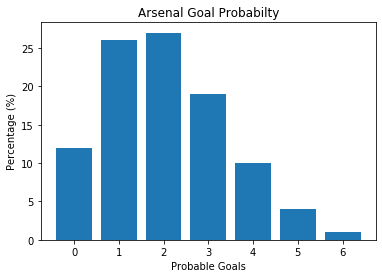

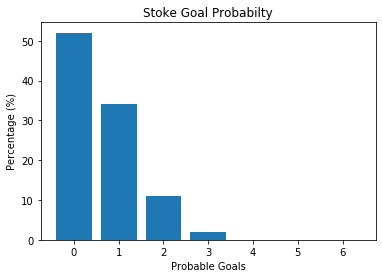

,home,away,probability
0,2,0,14.04
1,1,0,13.52
2,3,0,9.88
3,2,1,9.18
4,1,1,8.84


In [330]:
footy.average_goals_scored((1.36, 1.06))
footy.score_probability('Arsenal', 'Stoke').head()

This confirms that Arsenal had a 27% chance of scoring 2 goals and Stoke had a 51% chance of scoring no goals.  That the most likely score is 2-0 (14% probability) followed by 1-0 and 3-0 (13.52% and 9.88% respectively).

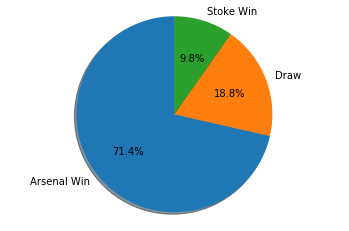

(70.02, 18.43, 9.56)

In [331]:
footy.outcome_probability('Arsenal', 'Stoke')

The probable outcome also matches what was in the article.

## Conclusion

Arsenal went on to win the game 4-1, so the probable outcome was correct, but the probable score of 2-0 was not.